# Imports

En esta parte se estara instalando la libreria simpleai para poder utilizarla en este notebook. 

In [ ]:
pip install simpleai

     |████████████████████████████████| 102kB 6.3MB/s 
  Created wheel for simpleai: filename=simpleai-0.8.2-cp37-none-any.whl size=100987 sha256=ef785dfdb6080bce951980f17825dbd9acf711465693af2745243dbbc01d58a6
  Stored in directory: /root/.cache/pip/wheels/eb/79/f6/e69832e2d3d025b69bc6342ef5b408c15bd81c26e949155bdc
Successfully built simpleai


Ahora se cargaran todas las librerias que se utilizaran para poder hacer el algoritmo.

In [ ]:
from simpleai.search import SearchProblem, astar
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
import struct
import numpy as np
import copy
import math
from IPython.core.display import HTML # Esto es solo para centrar las imágenes en las celdas de salida en el notebook.
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Funciones

Se declaran diferentes funciones arbitrarias que simplificaran nuestro trabajo en el algoritmo, por responsabilidad y respeto se debe de decir que estas funciones fueron escritas por el profesor Dr.  Edgar Covantes Osuna. Es importante recalcar que para que este codigo corra de manera correcta se debe de cargar el archivo data.bin en la linea 8. En este caso se utiliza un directorio a donde se encuentra este archivo, pero para una persona que no tiene acceso al mismo se recomienda cargar el archivo o cambiar el directorio al que se tiene en uso para resguardar el archivo data.bin.

In [ ]:
n_rows = 0
n_columns = 0
ori_scale = 0
new_scale = 0
sub_rate = 10


data_file = open(r'/content/drive/MyDrive/TEC/S4/Diseño de Agentes Inteligentes/Reto/Planeacion de Rutas para la Exploracion de Marte/data.bin', 'rb') # Remplazar con la dirección correcta.

def coordinates_to_state(coord):
    """
    This function converts the specified coordinates into a state string.

    coord : The coordinates to be converted.
    """
    return str(coord[0]) + ',' + str(coord[1])

def state_to_coordinates(state):
    """
    This function gests the coordinates specified by the a state string.

    state : The state string to be converted.
    """    
    #print(state)
    return [int(x) for x in state.split(',')]

def roundm(x):
    '''
    Esta función redondea exactamente en la mitad.
    '''
    i, f = divmod(x, 1)
    return int(i + ((f >= 0.5) if (x > 0) else (f > 0.5)))

def coordinates_to_row_column(x, y, n_rows, scale):
    row = n_rows - roundm(y/scale)
    col = roundm(x/scale)
    return [row, col]

def get_n_rows():
    # Cantidad de renglones de la imagen (INT32, 4 bytes)
    data = data_file.read(4)
    n_rows = int.from_bytes(data, byteorder='little')
    return n_rows

def get_n_columns():
    # Cantidad de columnas de la imagen (INT32, 4 bytes)
    data = data_file.read(4)
    n_columns = int.from_bytes(data, byteorder='little')
    return n_columns

def get_original_scale():
    # Escala de la imagen (metros/pixel) (FLOAT64, 8 bytes)
    data = data_file.read(8)
    scale = struct.unpack('d', data)
    scale = scale[0]
    #print('Scale:', scale, 'meters/pixel')
    return scale

def create_scaled_map(n_rows, n_columns, ori_scale, sub_rate):
    
    # Datos de la imagen (arreglo de nÃºmeros cÃ³dificados en float64, 8 bytes por cada pixel)
    image_size = n_rows * n_columns
    data = data_file.read(8*image_size) 

    # Transforma los datos de la imagen en un arreglo de numpy
    image_data = np.frombuffer(data)
    image_data = image_data.reshape((n_rows, n_columns))

    # Submuestrea la imagen original para reducir su tamaÃ±o (tambiÃ©n es posible escalara la imagen)
    new_scale = sub_rate*ori_scale
    image_data = image_data[0::sub_rate, 0::sub_rate]
    n_rows, n_columns = image_data.shape
    
    return n_rows, n_columns, new_scale, image_data
    
def plot_map(path, image_data):
    # Superfice en 2D
    cmap = copy.copy(plt.cm.get_cmap('autumn'))
    cmap.set_under(color='black')   

    ls = LightSource(315, 45)
    rgb = ls.shade(image_data, cmap=cmap, vmin = 0, vmax = image_data.max(), vert_exag=2, blend_mode='hsv')
    
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(rgb, cmap=cmap, vmin = 0, vmax = image_data.max(),
                   extent =[0, new_scale*new_columns, 0, new_scale*new_rows], 
                   interpolation ='nearest', origin ='upper')

    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Altura (m)')

    plt.title('Superficie de Marte')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    
    for i, (action, state) in enumerate(path):
        row, col = state_to_coordinates(state)
        if action == None:
            plt.scatter(row, col, color = 'blue')
        elif i == len(path) - 1:
            plt.scatter(row, col, color = 'red')
        else:
            plt.scatter(row, col, color = 'green')
    plt.show()

n_rows = get_n_rows()
n_columns = get_n_columns()
ori_scale = get_original_scale()

new_rows, new_columns, new_scale, image_data = create_scaled_map(n_rows, n_columns, ori_scale, sub_rate)

print('Rows:', n_rows)
print('Columns:', n_columns)
print('Scale:', ori_scale, 'meters/pixel')
print('\nAfter sub-sampling')
print('Sub-sampling:', sub_rate)
print('New Rows:', new_rows)
print('New Columns:', new_columns)
print('New scale:', new_scale, 'meters/pixel')

Rows: 18143
Columns: 7557
Scale: 1.0017330185711 meters/pixel

After sub-sampling
Sub-sampling: 10
New Rows: 1815
New Columns: 756
New scale: 10.017330185711 meters/pixel


# Problema Inicial

En esta parte se estara declarando la Clase RutaExplorarMarte, la cual nos ayudara a poder declarar el problema inicial y luego resolver el problema utilizando el algoritmo a estrella que se encuentra en la libreria simpleai como una funcion. 

Primero que nada se tiene que declarar una funcion que inicialize el problema, esta tendra el esta del problema, el estado inicial y objetivo, al igual que los objetivos en fila y columna como variables.

Es esencial crear la funcion accion o action, donde se tendra que hacer un metodo que regrese una lista con todas las posibles acciones a tomar, esto se hace con una lista ya establecida de las acciones posibles a tomar y con una lista vacia de las acciones que se regresaran al final de la funcion. Se crea un loop for donde se pone ve que consecuencias tendria el tomar cada una de las acciones posibles, las cuales son, en nuestro caso, el moverse en las ocho posibles direcciones hacia uno de nuestros vecinos. Una vez que vemos cual es la consecuencia, hacemos pasar el estado que se tendria si se toma esta accion por una restriccion, la cual es que no debe de diferir en altura por mas de 1 metro.

Para saber los resultados de nuestra accion debemos de mandar llamar la funcion result, la cual solo nos cambiara nuestras coordenadas dependiendo de que accion se toma.

La funcion isgoal o esobjetivo nos regresa simplemente si ya estamos en nuestro objetivo o si todavia tenemos que seguir corriendo nuestro codigo.

La funcion costo nos regresa el costo de tomar una accion segun nuestra circumstancia actual.

La funcion heuristica nos dice que tan lejos estamos actualmente de nuestro objetivo y busca darnos una idea de hacia donde nos tenemos que mover.

In [ ]:
class RutaExplorarMarte(SearchProblem):
    
    #Esta clase es usada para definir el problema de la planeación de rutas para la exploración de Marte.
    
    
    def __init__(self, initial_state, goal_state):
        '''
        Constructor de la clase. Se utiliza para inicializar el problema de la planeación de rutas para la exploración de 
        Marte. 
        '''
        self.initial_state = initial_state
        self.state = initial_state
        self.goal = goal_state
        self.goal_row, self.goal_col = state_to_coordinates(goal_state)
    
    def actions(self, state):
        '''
        This method returns a list with the possible actions that can be performed according to
        the specified current state.

        state : The game state to evaluate.
        '''
        self.state

        Pos_actions = ["up","down","left","right","up left","up right","down left", "down right"]
        
        actions = []

        for action in Pos_actions:
          x, y = state_to_coordinates(self.state)
          mayAction = self.result(self.state, action)
          xx, yy = state_to_coordinates(mayAction)
          x, y = coordinates_to_row_column(x,y, new_rows, new_scale)
          xx, yy = coordinates_to_row_column(xx, yy, new_rows, new_scale)
          height_difference = image_data[xx][yy] - image_data[x][y]
          # print(height_difference)
          if height_difference <= 1 :
              actions.append(action)
        # print(actions)
        # print(self.state)
        return actions
        
    def result(self, state, action):
        '''
        This method returns the new state obtained after performing the specified action.

        state : The game state to be modified.
        action : The action be perform on the specified state.

        
        '''
        row, col = state_to_coordinates(state)

        if action.count("up"):
            row -= 10
        elif action.count("down"):
            row += 10
        elif action.count("left"):
            col -= 10
        elif action.count("right"):
            col += 10


        return coordinates_to_state([row, col])
        
    def is_goal(self, state):
        '''
        This method evaluates whether the specified state is the goal state.

        state : The game state to test.
        ''' 
        row, col = state_to_coordinates(state)
        return self.goal_row == row and self.goal_col == col
        
    def cost(self, state, action, state2):
        '''
        This method receives two states and an action, and returns
        the cost of applying the action from the first state to the
        second state.
        
        state : The initial game state.
        action : The action used to generate state2.
        state2 : The game state obtained after applying the specfied action.
        '''
        row, col = state_to_coordinates(state)
        row2, col2 = state_to_coordinates(state2)
        return math.sqrt((row2 - row)**2 + abs(col2 - col)**2)
        
    def heuristic(self, state):
        '''
        This method returns an estimate of the distance from the specified state to 
        the goal using the euclidean distance.

        state : The game state to evaluate.
        ''' 
        row, col = state_to_coordinates(state)
        distance = math.sqrt((row-self.goal_row)**2 + (col-self.goal_col)**2)
        return distance

En esta seccion hacemos el mapa de la superficie de marte y hacemos un plot de nuestro estado inicial y nuestro estado final para poder mejor visualizar este problema. Nuestros estados los tenemos en una lista llamada path, donde esta tendra todos los pasos que tomaremos en nuestro camino para llegar a nuestro destino.

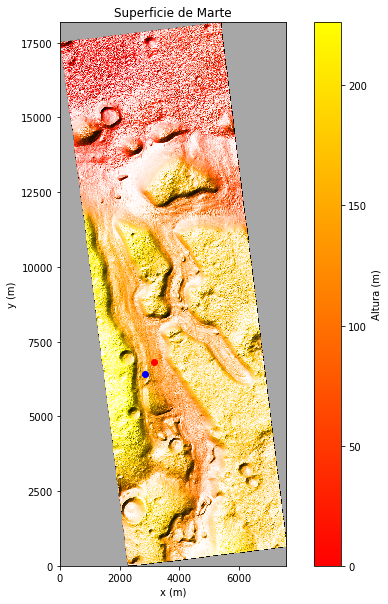

In [ ]:
# Estado inicial en formato coordenada x,y.
initial_state = '2850,6400'

# Estado objetivo en formato coordenada x,y.
goal_state = '3150,6800'

path = []

path.append((None, initial_state))
path.append(('end', goal_state))

plot_map(path, image_data)

En este bloque de codigo tenemos la creacion de nuestro objetvo problema y la resolucion del mismo utilizando el algoritmo astar de la libreria simpleai, utilizamos graph_search para agilizar el codigo y no repetir estados.

In [ ]:
# Define cost of moving around the map
cost_regular = 1.0
cost_diagonal = 1.4

# Creacion del objeto RutaExplorarMarte
problem = RutaExplorarMarte(initial_state, goal_state)
# Obtenemos nuestra respuesta utilizando la funcion astar de simpleai, usamos graph_search = true para ahorrar tiempo.
result = astar(problem, graph_search=True)

En el bloque de codigo inferior podemos observar como se obtiene nuestra respuesta, se imprimen la coordenada objetivo, la longitud del camino, es decir, cuantos pasos nos tomo llegar a nuestro destino, y el camino paso por paso.

In [ ]:
print('Coordenada Objetivo: ', result.state)
print('Longitud del camino: ', len(result.path()))
print(result.path())

Coordenada Objetivo:  3150,6800
Longitud del camino:  71
[(None, '2850,6400'), ('right', '2850,6410'), ('right', '2850,6420'), ('right', '2850,6430'), ('right', '2850,6440'), ('right', '2850,6450'), ('right', '2850,6460'), ('right', '2850,6470'), ('right', '2850,6480'), ('right', '2850,6490'), ('right', '2850,6500'), ('right', '2850,6510'), ('down', '2860,6510'), ('right', '2860,6520'), ('down', '2870,6520'), ('right', '2870,6530'), ('down', '2880,6530'), ('right', '2880,6540'), ('down', '2890,6540'), ('right', '2890,6550'), ('down', '2900,6550'), ('right', '2900,6560'), ('down', '2910,6560'), ('right', '2910,6570'), ('down', '2920,6570'), ('right', '2920,6580'), ('down', '2930,6580'), ('right', '2930,6590'), ('down', '2940,6590'), ('right', '2940,6600'), ('down', '2950,6600'), ('right', '2950,6610'), ('down', '2960,6610'), ('right', '2960,6620'), ('down', '2970,6620'), ('right', '2970,6630'), ('down', '2980,6630'), ('down', '2990,6630'), ('right', '2990,6640'), ('down', '3000,6640'), 

Se hace un plot del mapa con nuestro camino para poder visualizar cual es el camino que se debe de tomar para llegar a nuestro objetivo.

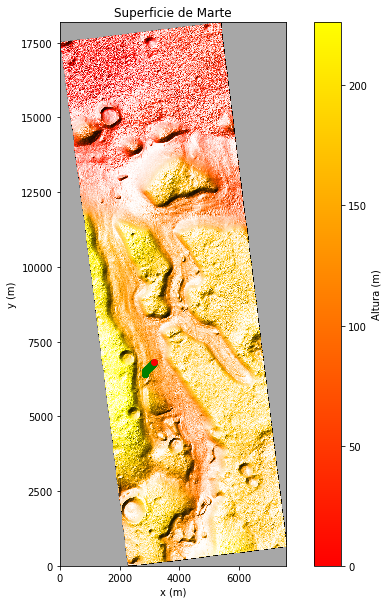

In [ ]:
plot_map(result.path(), image_data)

## Prueba con distancia de mas de 500 metros y menos de 1000 metros

En esta prueba estaremos utilizando la clase de rutaexplorarmarte y el algoritmo aestrella de la libreria simpleai. Cambiamor nuestro estado inicial para que obtengamos una distancia entre el estado inicial y final de 700.

In [ ]:
# Estado inicial en formato coordenada x,y.
initial_state = '2650,6100'

# Estado objetivo en formato coordenada x,y.
goal_state = '3150,6800'

path = []

path.append((None, initial_state))
path.append(('end', goal_state))

# Creacion del objeto RutaExplorarMarte
problem = RutaExplorarMarte(initial_state, goal_state)
# Obtenemos nuestra respuesta utilizando la funcion astar de simpleai, usamos graph_search = true para ahorrar tiempo.
result = astar(problem, graph_search=True)

In [ ]:
print('Coordenada Objetivo: ', result.state)
print('Longitud del camino: ', len(result.path()))
print(result.path())

Coordenada Objetivo:  3150,6800
Longitud del camino:  121
[(None, '2650,6100'), ('right', '2650,6110'), ('right', '2650,6120'), ('right', '2650,6130'), ('right', '2650,6140'), ('right', '2650,6150'), ('right', '2650,6160'), ('right', '2650,6170'), ('right', '2650,6180'), ('right', '2650,6190'), ('right', '2650,6200'), ('right', '2650,6210'), ('right', '2650,6220'), ('right', '2650,6230'), ('right', '2650,6240'), ('right', '2650,6250'), ('right', '2650,6260'), ('right', '2650,6270'), ('right', '2650,6280'), ('right', '2650,6290'), ('right', '2650,6300'), ('down', '2660,6300'), ('right', '2660,6310'), ('right', '2660,6320'), ('down', '2670,6320'), ('down', '2680,6320'), ('right', '2680,6330'), ('right', '2680,6340'), ('down', '2690,6340'), ('down', '2700,6340'), ('right', '2700,6350'), ('down', '2710,6350'), ('right', '2710,6360'), ('right', '2710,6370'), ('down', '2720,6370'), ('down', '2730,6370'), ('right', '2730,6380'), ('right', '2730,6390'), ('down', '2740,6390'), ('right', '2740,6

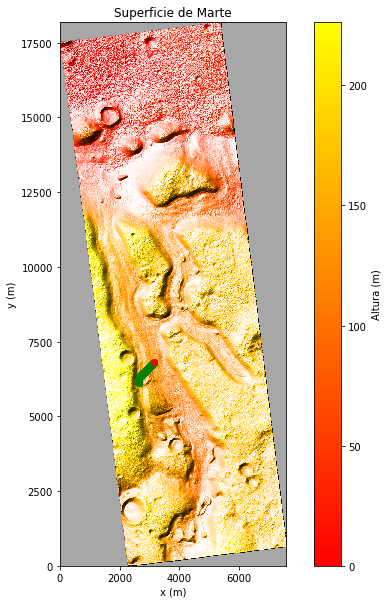

In [ ]:
plot_map(result.path(), image_data)

## Prueba con distancia de mas de 1000 metros y menos de 5000 metros

En esta parte se hace lo mismo que en la parte anterior, pero ahora nuestra distancia es de 3089.

In [ ]:
# Estado inicial en formato coordenada x,y.
initial_state = '2650,6100'

# Estado objetivo en formato coordenada x,y.
goal_state = '4150,8800'

path = []

path.append((None, initial_state))
path.append(('end', goal_state))

# Creacion del objeto RutaExplorarMarte
problem = RutaExplorarMarte(initial_state, goal_state)
# Obtenemos nuestra respuesta utilizando la funcion astar de simpleai, usamos graph_search = true para ahorrar tiempo.
result = astar(problem, graph_search=True)

In [ ]:
print('Coordenada Objetivo: ', result.state)
print('Longitud del camino: ', len(result.path()))
print(result.path())

Coordenada Objetivo:  4150,8800
Longitud del camino:  421
[(None, '2650,6100'), ('right', '2650,6110'), ('right', '2650,6120'), ('right', '2650,6130'), ('right', '2650,6140'), ('right', '2650,6150'), ('right', '2650,6160'), ('right', '2650,6170'), ('right', '2650,6180'), ('right', '2650,6190'), ('right', '2650,6200'), ('right', '2650,6210'), ('right', '2650,6220'), ('right', '2650,6230'), ('right', '2650,6240'), ('right', '2650,6250'), ('right', '2650,6260'), ('right', '2650,6270'), ('right', '2650,6280'), ('right', '2650,6290'), ('right', '2650,6300'), ('right', '2650,6310'), ('right', '2650,6320'), ('right', '2650,6330'), ('right', '2650,6340'), ('right', '2650,6350'), ('right', '2650,6360'), ('right', '2650,6370'), ('right', '2650,6380'), ('right', '2650,6390'), ('right', '2650,6400'), ('right', '2650,6410'), ('right', '2650,6420'), ('right', '2650,6430'), ('right', '2650,6440'), ('right', '2650,6450'), ('right', '2650,6460'), ('right', '2650,6470'), ('right', '2650,6480'), ('right'

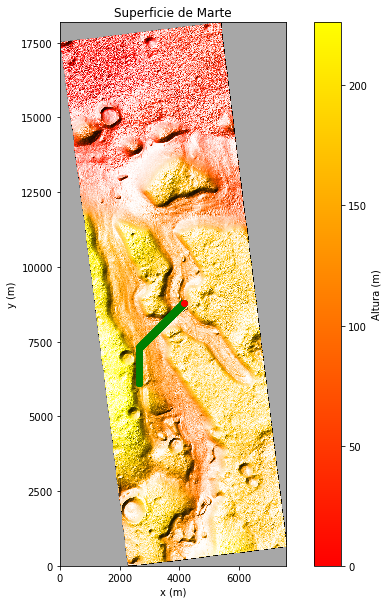

In [ ]:
plot_map(result.path(), image_data)

## Prueba con distancia de mas de 10000 metros 

En esta ultima parte tenemos que nuestra distancia es de 10701 entre el punto inicial y el punto final.

In [ ]:
# Estado inicial en formato coordenada x,y.
initial_state = '2650,6100'

# Estado objetivo en formato coordenada x,y.
goal_state = '2850,16800'

path = []

path.append((None, initial_state))
path.append(('end', goal_state))

# Creacion del objeto RutaExplorarMarte
problem = RutaExplorarMarte(initial_state, goal_state)
# Obtenemos nuestra respuesta utilizando la funcion astar de simpleai, usamos graph_search = true para ahorrar tiempo.
result = astar(problem, graph_search=True)

In [ ]:
print('Coordenada Objetivo: ', result.state)
print('Longitud del camino: ', len(result.path()))
print(result.path())

Coordenada Objetivo:  2150,16800
Longitud del camino:  1121
[(None, '2650,6100'), ('right', '2650,6110'), ('right', '2650,6120'), ('right', '2650,6130'), ('right', '2650,6140'), ('right', '2650,6150'), ('right', '2650,6160'), ('right', '2650,6170'), ('right', '2650,6180'), ('right', '2650,6190'), ('right', '2650,6200'), ('right', '2650,6210'), ('right', '2650,6220'), ('right', '2650,6230'), ('right', '2650,6240'), ('right', '2650,6250'), ('right', '2650,6260'), ('right', '2650,6270'), ('right', '2650,6280'), ('right', '2650,6290'), ('right', '2650,6300'), ('right', '2650,6310'), ('right', '2650,6320'), ('right', '2650,6330'), ('right', '2650,6340'), ('right', '2650,6350'), ('right', '2650,6360'), ('right', '2650,6370'), ('right', '2650,6380'), ('right', '2650,6390'), ('right', '2650,6400'), ('right', '2650,6410'), ('right', '2650,6420'), ('right', '2650,6430'), ('right', '2650,6440'), ('right', '2650,6450'), ('right', '2650,6460'), ('right', '2650,6470'), ('right', '2650,6480'), ('righ

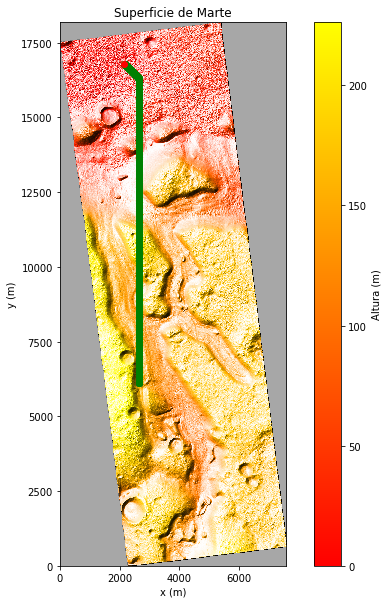

In [ ]:
plot_map(result.path(), image_data)

# Preguntas

1. ¿En qué casos el algoritmo es capaz de resolver el problema en un tiempo aceptable? 
2. En los casos que el algoritmo no encuentra un resultado, ¿qué acciones se podrían realizar para ayudar al algoritmo a resolver el problema?

1. El algoritmo es mas capaz de resolver el problema en casos donde la distancia es mas corta entre el punto inicial y el punto objetivo, esto no quiere decir que el tiempo que toma en resolver problemas de distancia mas larga, como la que se encuentra en la distancia de mas de 10000 metros, es inaceptable o muy largo, pero si requiere un poco mas de tiempo para resolver. Si se tuviera que mencionar cual es el mejor en terminos de tiempo tomado para resovler el problema en los casos resueltos, seria en el inicial o en el que tiene una distancia de entre 500 y 1000 metros.

2. Se podria crear alguna funcion que deje que termine de buscar cuando se aproxime a un cierto rango de su objetivo, asumiendo que es imposible que pueda llegar a su objetivo, o tambien se podria utilizar en otros casos.